# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:06<00:00, 8.98KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

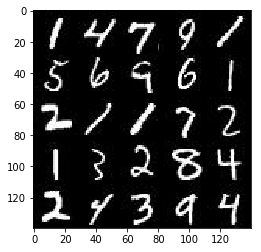

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

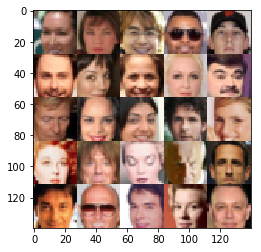

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/home/demo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [38]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), 
                                 name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='input_z')

    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/demo/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/demo/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/demo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/demo/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/demo/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/demo/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", 

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [39]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    keep_prob = 0.8
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 32, 5, strides=1, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        relu1 = tf.maximum(alpha * x1, x1)
        #28x28x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        dp2 = tf.nn.dropout(relu2, keep_prob)
        #14x14x64
        
        x3 = tf.layers.conv2d(dp2, 128, 5, strides=1, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        dp3 = tf.nn.dropout(relu3, keep_prob)
        #14x14x128
        
        x4 = tf.layers.conv2d(dp3, 256, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        dp4 = tf.nn.dropout(relu4, keep_prob)
        #7x7x256
                        
        flat = tf.reshape(dp4, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        #1

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [40]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #reuse_param=True 
    alpha = 0.2
    keep_prob = 0.5
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        dp2 = tf.nn.dropout(x2, keep_prob)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(dp2, 64, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        dp3 = tf.nn.dropout(x3, keep_prob)
        # 14x14x64 now
        
        x4 = tf.layers.conv2d_transpose(dp3, 32, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        dp4 = tf.nn.dropout(x4, keep_prob)
        # 28x28x32 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(dp4, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [41]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [42]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
   
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # scaling the batch images by a factor of 2 to make it in the range of [-1 1]
                batch_images = batch_images * 2
                steps+=1
        
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                # run the optimization for the generator twice to make sure that the discriminator loss does not go to zero.
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, lr:learning_rate, input_real:batch_images})
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, lr:learning_rate, input_real:batch_images})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                    _ = show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)


                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5568... Generator Loss: 2.9189


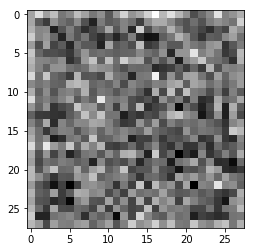

Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 1.1639


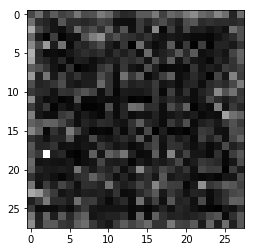

Epoch 1/2... Discriminator Loss: 0.5473... Generator Loss: 2.5226


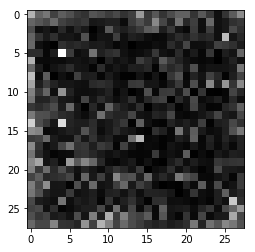

Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 1.3642


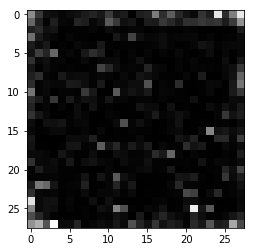

Epoch 1/2... Discriminator Loss: 0.5559... Generator Loss: 3.0186


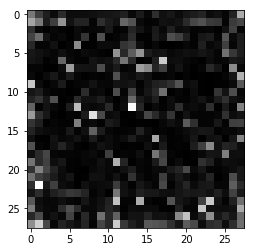

Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 1.5243


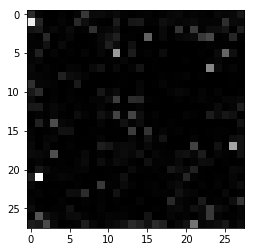

Epoch 1/2... Discriminator Loss: 1.4734... Generator Loss: 3.1463


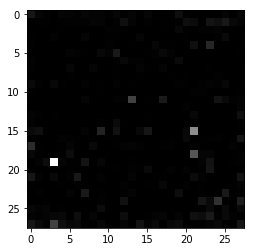

Epoch 1/2... Discriminator Loss: 0.6567... Generator Loss: 2.4016


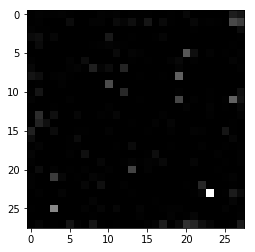

Epoch 1/2... Discriminator Loss: 0.7285... Generator Loss: 2.0966


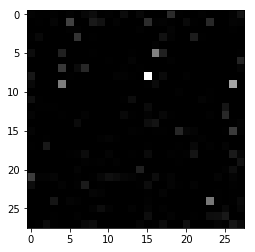

Epoch 1/2... Discriminator Loss: 0.9922... Generator Loss: 2.7617


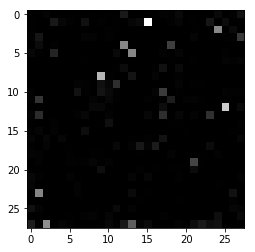

Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 1.3283


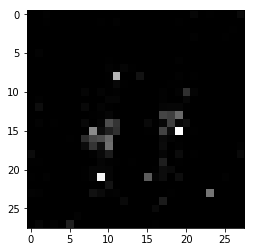

Epoch 1/2... Discriminator Loss: 0.9122... Generator Loss: 2.3869


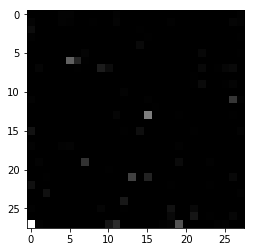

Epoch 1/2... Discriminator Loss: 0.9673... Generator Loss: 3.0426


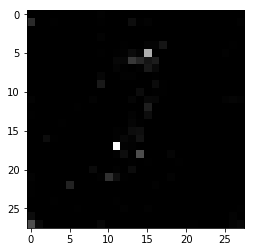

Epoch 1/2... Discriminator Loss: 0.8945... Generator Loss: 1.7889


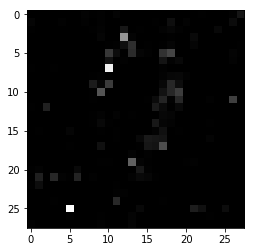

Epoch 1/2... Discriminator Loss: 1.5233... Generator Loss: 0.6906


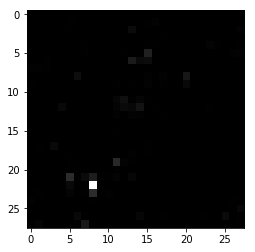

Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.6585


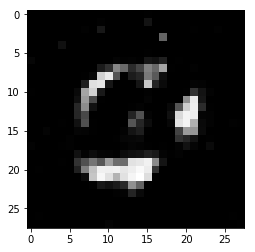

Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 1.3853


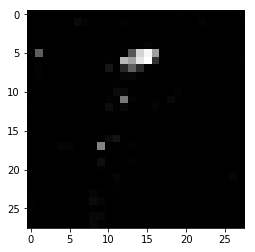

Epoch 1/2... Discriminator Loss: 1.1084... Generator Loss: 1.0383


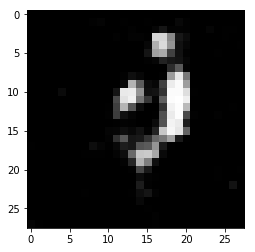

Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 2.8700


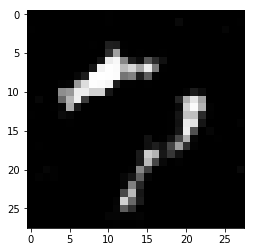

Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 2.1969


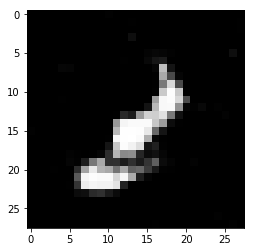

Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 2.6522


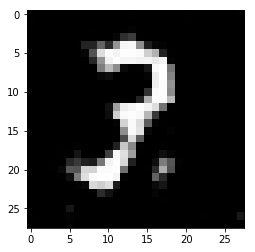

Epoch 1/2... Discriminator Loss: 0.8806... Generator Loss: 2.8048


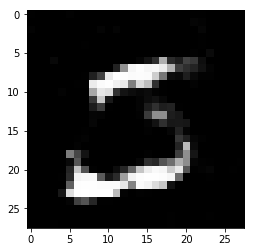

Epoch 1/2... Discriminator Loss: 2.3722... Generator Loss: 0.3384


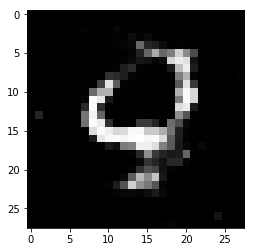

Epoch 1/2... Discriminator Loss: 0.8415... Generator Loss: 1.9196


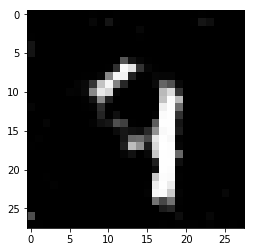

Epoch 1/2... Discriminator Loss: 0.8833... Generator Loss: 1.2779


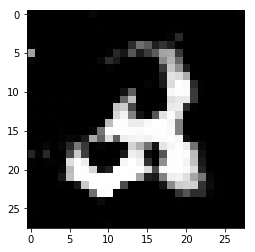

Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 2.9725


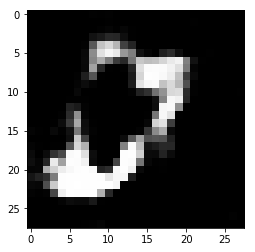

Epoch 1/2... Discriminator Loss: 0.9995... Generator Loss: 1.1217


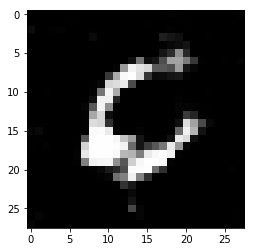

Epoch 1/2... Discriminator Loss: 1.1575... Generator Loss: 1.0435


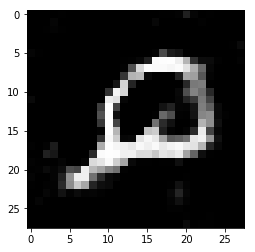

Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 2.4302


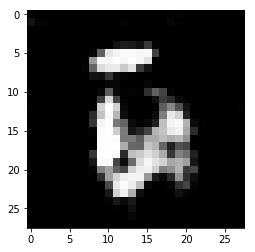

Epoch 1/2... Discriminator Loss: 0.7791... Generator Loss: 2.2849


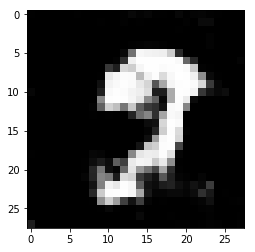

Epoch 1/2... Discriminator Loss: 1.0668... Generator Loss: 1.1706


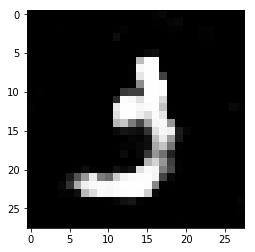

Epoch 1/2... Discriminator Loss: 0.9432... Generator Loss: 1.3032


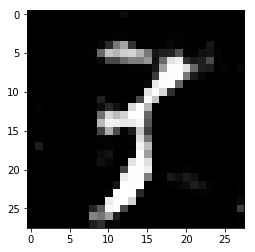

Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 1.8328


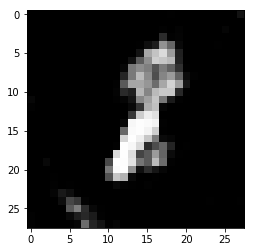

Epoch 1/2... Discriminator Loss: 0.9774... Generator Loss: 2.1014


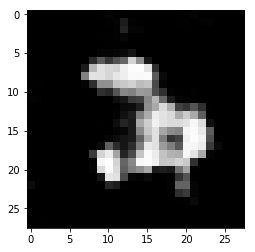

Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 2.8738


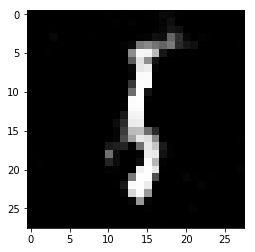

Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 1.6241


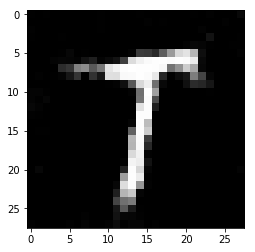

Epoch 1/2... Discriminator Loss: 0.9856... Generator Loss: 1.8651


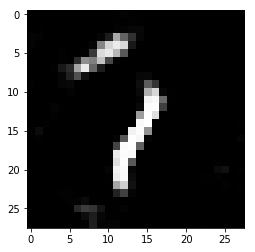

Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 0.7819


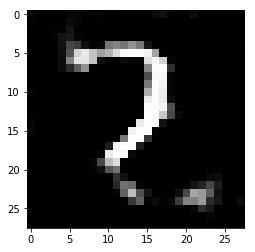

Epoch 1/2... Discriminator Loss: 0.9379... Generator Loss: 1.4065


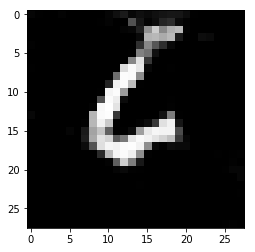

Epoch 1/2... Discriminator Loss: 1.0407... Generator Loss: 2.3593


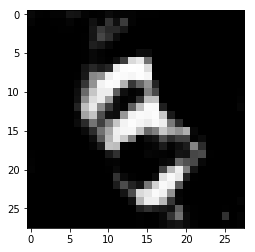

Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 1.5751


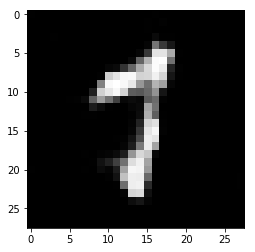

Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 2.7303


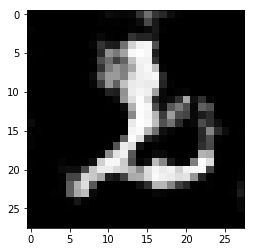

Epoch 1/2... Discriminator Loss: 0.9001... Generator Loss: 2.1224


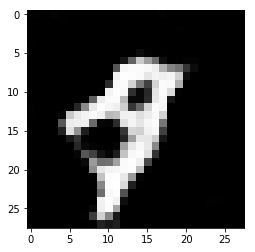

Epoch 1/2... Discriminator Loss: 1.7958... Generator Loss: 0.4863


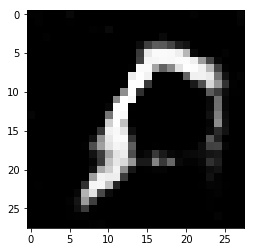

Epoch 1/2... Discriminator Loss: 1.0465... Generator Loss: 1.1174


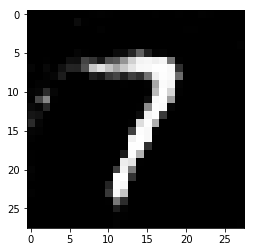

Epoch 1/2... Discriminator Loss: 1.3936... Generator Loss: 0.6764


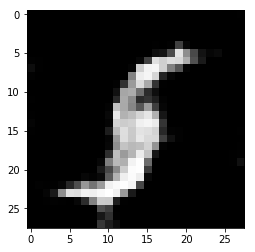

Epoch 2/2... Discriminator Loss: 0.8983... Generator Loss: 1.3362


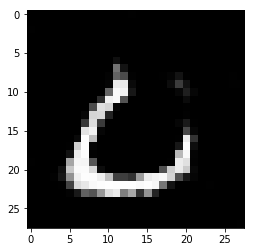

Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 1.3086


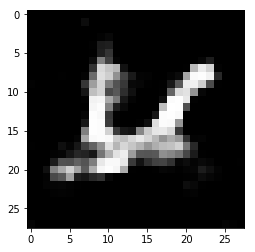

Epoch 2/2... Discriminator Loss: 0.9430... Generator Loss: 1.6523


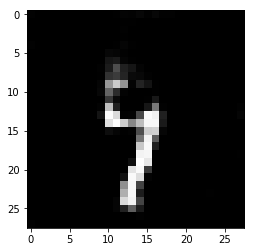

Epoch 2/2... Discriminator Loss: 1.0903... Generator Loss: 2.2364


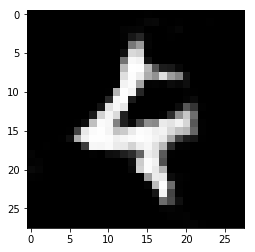

Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 2.3308


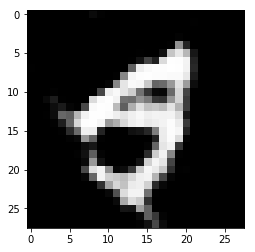

Epoch 2/2... Discriminator Loss: 1.0276... Generator Loss: 1.2191


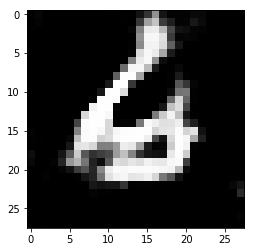

Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 3.2196


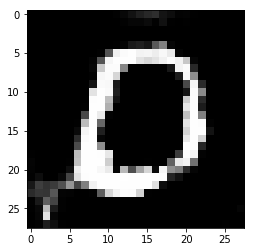

Epoch 2/2... Discriminator Loss: 0.8652... Generator Loss: 2.1401


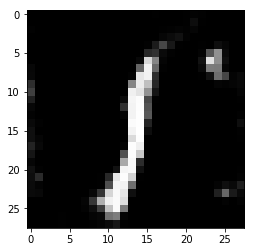

Epoch 2/2... Discriminator Loss: 1.1891... Generator Loss: 0.8729


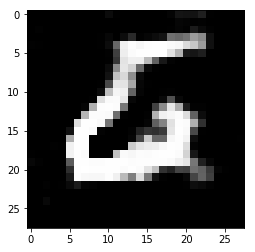

Epoch 2/2... Discriminator Loss: 0.9015... Generator Loss: 1.7574


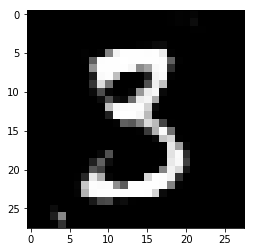

Epoch 2/2... Discriminator Loss: 1.4206... Generator Loss: 0.6785


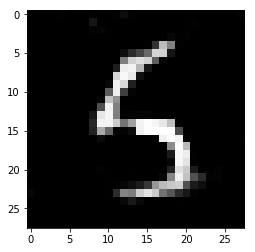

Epoch 2/2... Discriminator Loss: 0.9288... Generator Loss: 1.3315


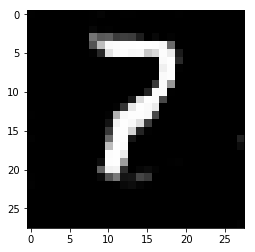

Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 2.1428


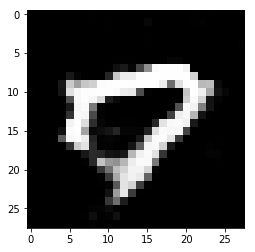

Epoch 2/2... Discriminator Loss: 1.0119... Generator Loss: 1.3215


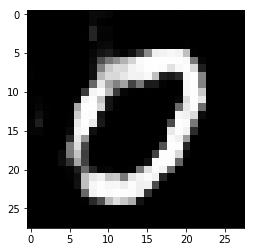

Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 2.0424


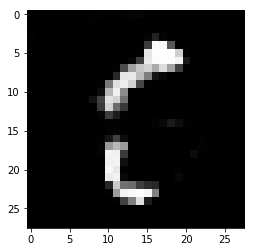

Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.8712


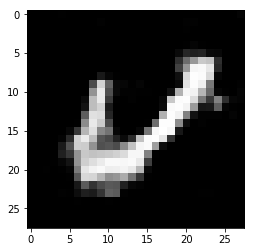

Epoch 2/2... Discriminator Loss: 0.8922... Generator Loss: 1.3492


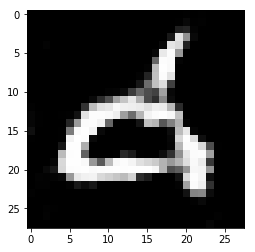

Epoch 2/2... Discriminator Loss: 0.9890... Generator Loss: 0.9943


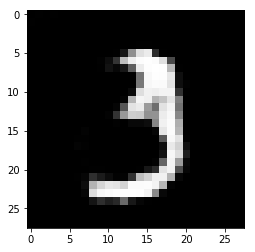

Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 1.5328


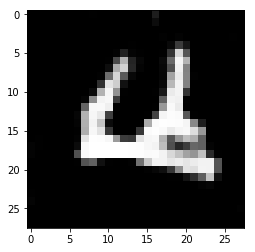

Epoch 2/2... Discriminator Loss: 0.9131... Generator Loss: 1.9746


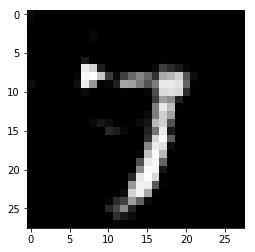

Epoch 2/2... Discriminator Loss: 1.3960... Generator Loss: 3.0575


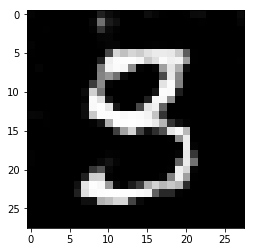

Epoch 2/2... Discriminator Loss: 0.8829... Generator Loss: 1.3878


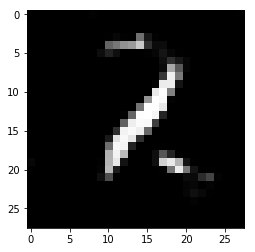

Epoch 2/2... Discriminator Loss: 0.9744... Generator Loss: 1.7999


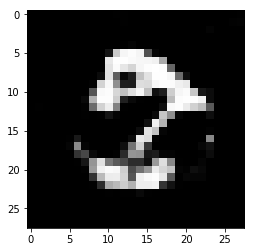

Epoch 2/2... Discriminator Loss: 1.5501... Generator Loss: 0.5750


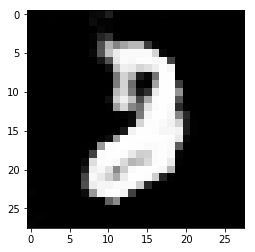

Epoch 2/2... Discriminator Loss: 0.8766... Generator Loss: 1.1658


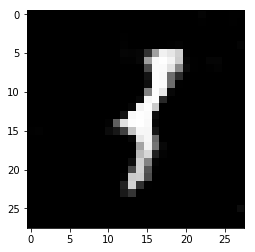

Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 2.0928


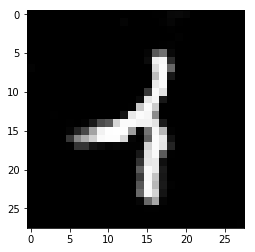

Epoch 2/2... Discriminator Loss: 0.9646... Generator Loss: 2.2321


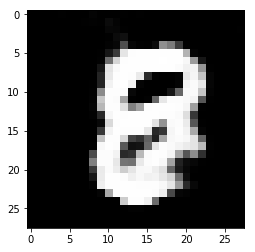

Epoch 2/2... Discriminator Loss: 1.2074... Generator Loss: 0.9795


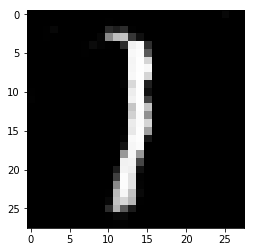

Epoch 2/2... Discriminator Loss: 1.2024... Generator Loss: 1.9518


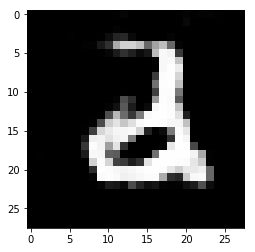

Epoch 2/2... Discriminator Loss: 3.2450... Generator Loss: 0.1098


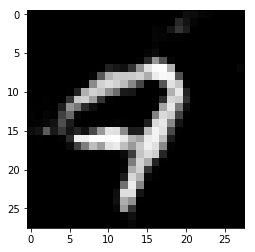

Epoch 2/2... Discriminator Loss: 0.8593... Generator Loss: 1.6529


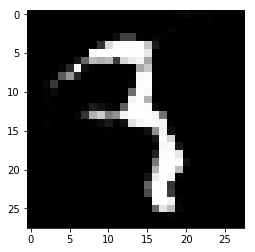

Epoch 2/2... Discriminator Loss: 0.9285... Generator Loss: 2.1714


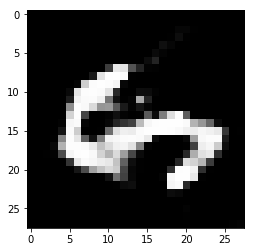

Epoch 2/2... Discriminator Loss: 0.9617... Generator Loss: 1.2794


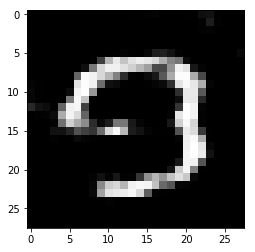

Epoch 2/2... Discriminator Loss: 0.8349... Generator Loss: 1.4792


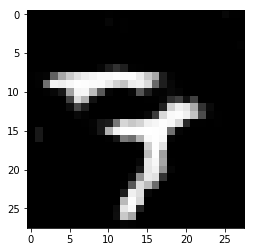

Epoch 2/2... Discriminator Loss: 1.4047... Generator Loss: 2.9150


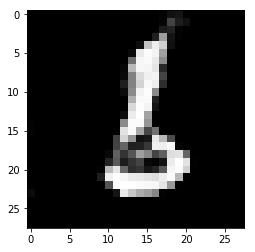

Epoch 2/2... Discriminator Loss: 0.8315... Generator Loss: 1.8213


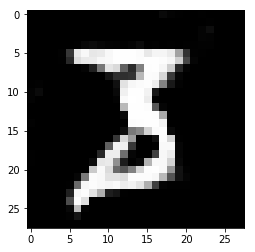

Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 1.7940


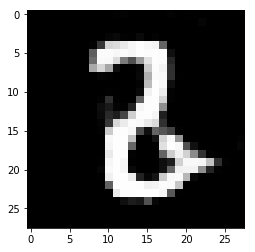

Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 1.7505


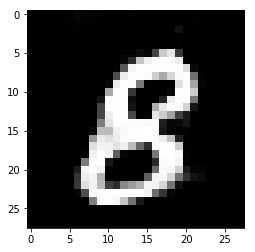

Epoch 2/2... Discriminator Loss: 1.0883... Generator Loss: 0.9633


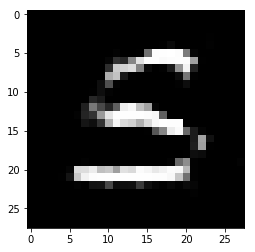

Epoch 2/2... Discriminator Loss: 0.7670... Generator Loss: 1.5946


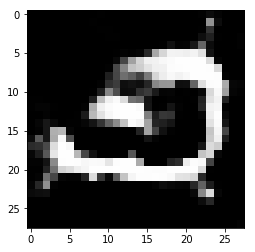

Epoch 2/2... Discriminator Loss: 0.7914... Generator Loss: 1.8630


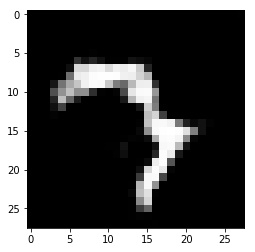

Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 1.4883


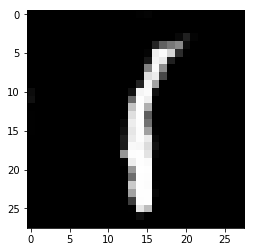

Epoch 2/2... Discriminator Loss: 0.9786... Generator Loss: 3.0397


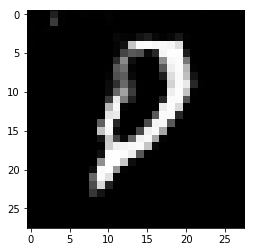

Epoch 2/2... Discriminator Loss: 0.7963... Generator Loss: 1.9121


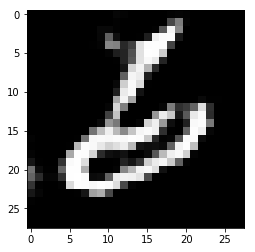

Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 1.9022


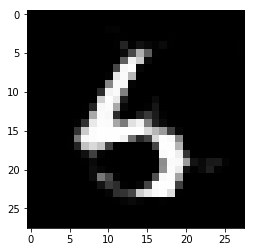

Epoch 2/2... Discriminator Loss: 1.6390... Generator Loss: 2.6622


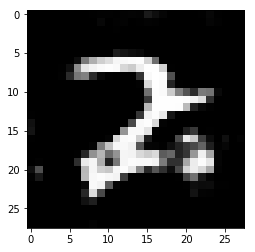

Epoch 2/2... Discriminator Loss: 1.0892... Generator Loss: 1.3559


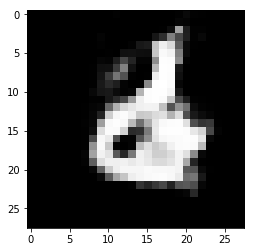

In [45]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4695... Generator Loss: 3.1660


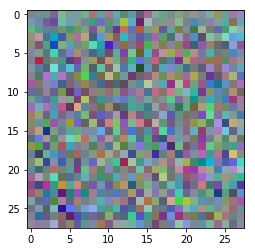

Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 3.7103


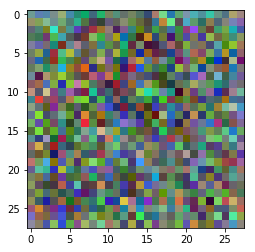

Epoch 1/1... Discriminator Loss: 0.5967... Generator Loss: 2.5248


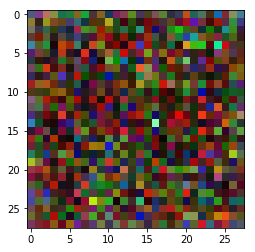

Epoch 1/1... Discriminator Loss: 0.5041... Generator Loss: 6.2040


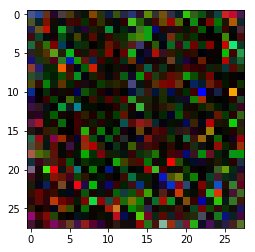

Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 3.6312


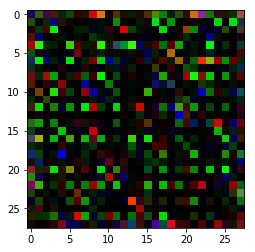

Epoch 1/1... Discriminator Loss: 0.4459... Generator Loss: 4.2475


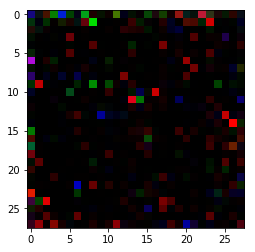

Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 2.4425


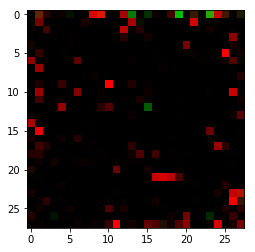

Epoch 1/1... Discriminator Loss: 0.5971... Generator Loss: 3.3816


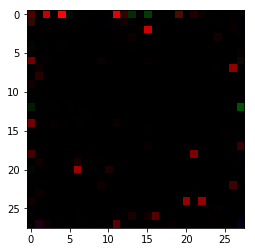

Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 2.4082


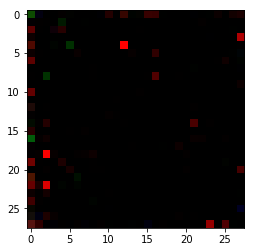

Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 2.1201


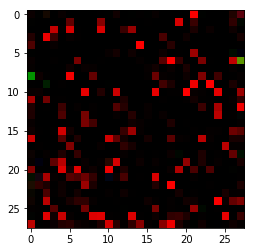

Epoch 1/1... Discriminator Loss: 0.4587... Generator Loss: 3.1061


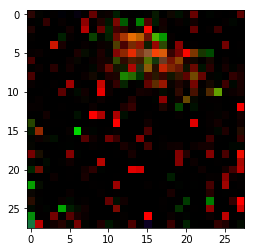

Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 3.8579


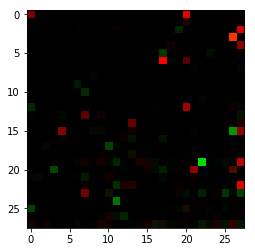

Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.7124


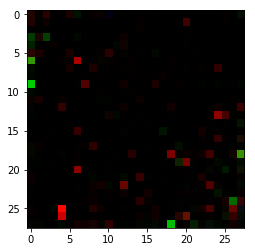

Epoch 1/1... Discriminator Loss: 0.5642... Generator Loss: 2.2429


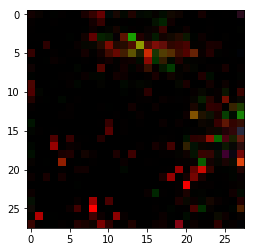

Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 2.7243


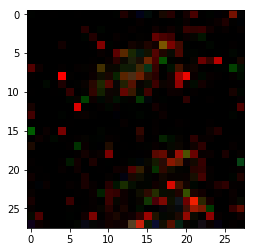

Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 1.7210


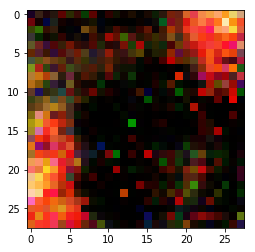

Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 3.3761


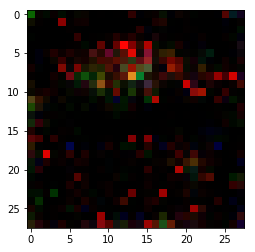

Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 3.3424


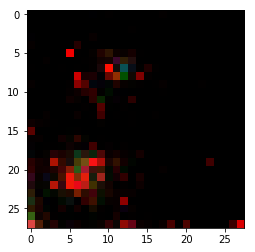

Epoch 1/1... Discriminator Loss: 1.6101... Generator Loss: 0.9303


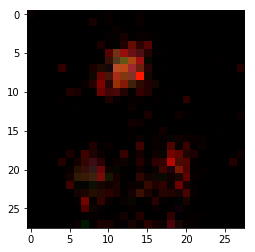

Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 3.3386


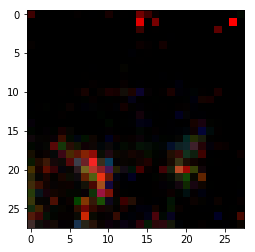

Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 2.7165


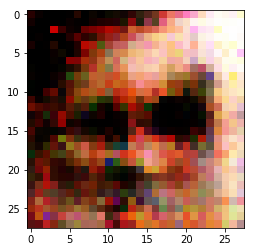

Epoch 1/1... Discriminator Loss: 0.5503... Generator Loss: 2.7177


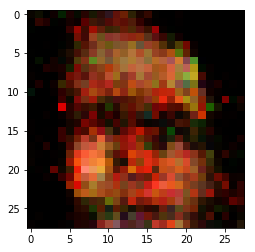

Epoch 1/1... Discriminator Loss: 0.5454... Generator Loss: 2.3520


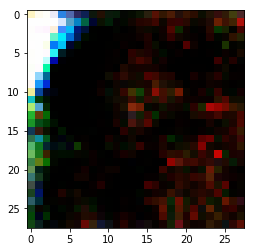

Epoch 1/1... Discriminator Loss: 0.5847... Generator Loss: 2.5425


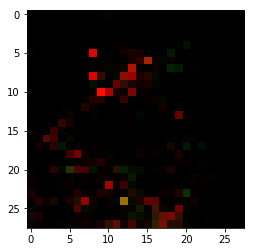

Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 3.0144


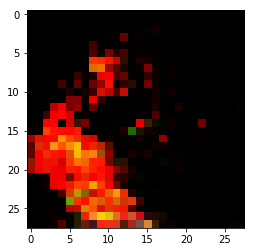

Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 2.7568


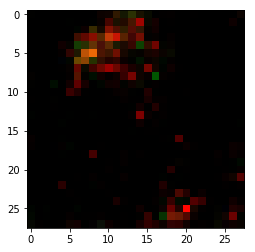

Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 2.6294


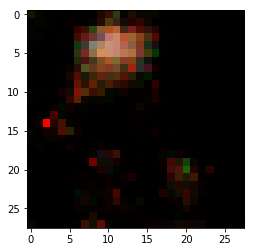

Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.6462


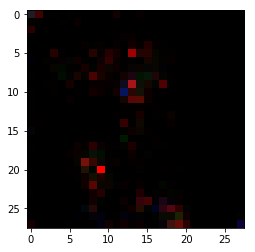

Epoch 1/1... Discriminator Loss: 0.7097... Generator Loss: 2.9086


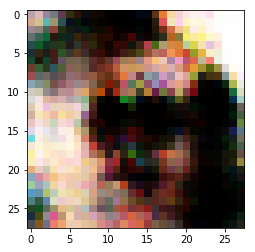

Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 2.2068


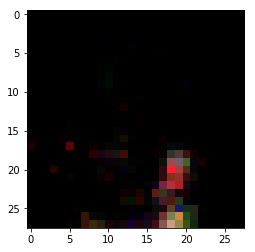

Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 3.0795


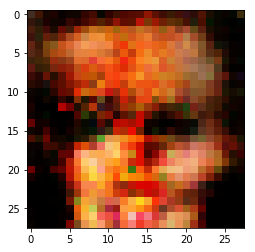

Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.6097


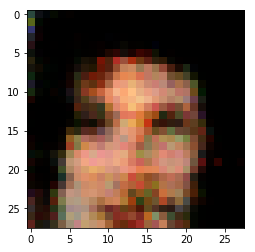

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 4.7876


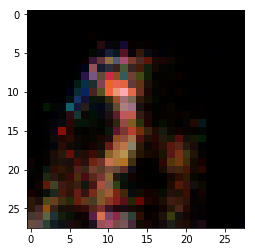

Epoch 1/1... Discriminator Loss: 0.7726... Generator Loss: 2.1423


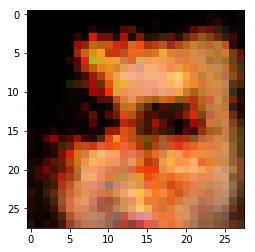

Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 3.4922


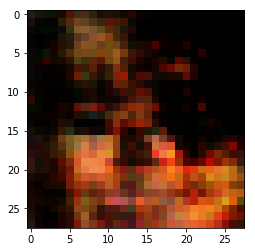

Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 1.5650


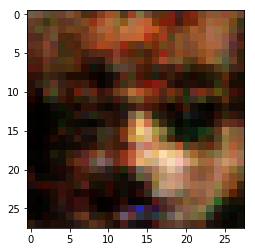

Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 1.0767


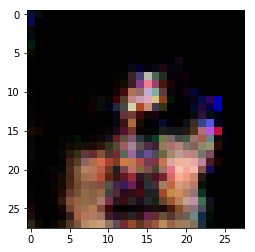

Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.8521


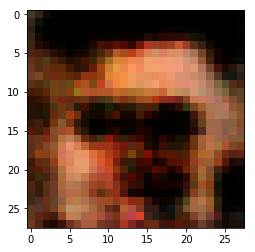

Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 2.1163


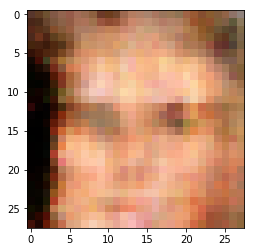

Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.4935


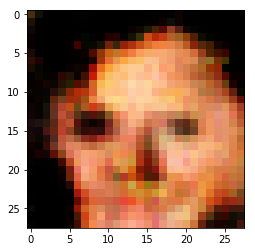

Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.8000


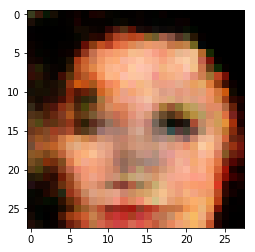

Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.4689


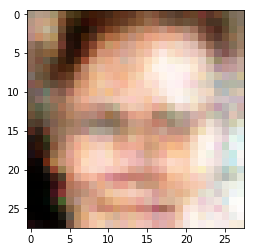

Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.9594


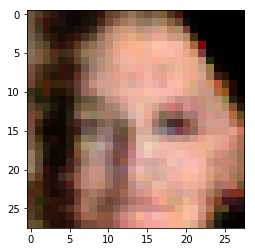

Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 1.5819


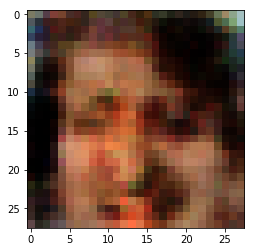

Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 2.1666


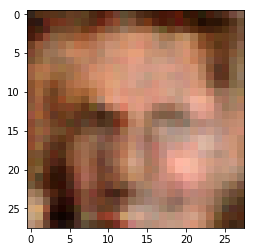

Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.9952


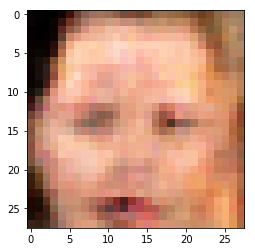

Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.5220


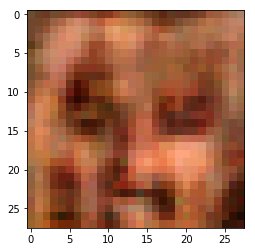

Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 2.2575


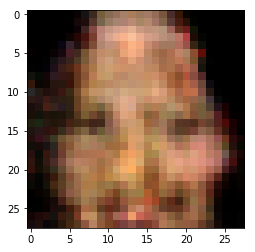

Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 3.6579


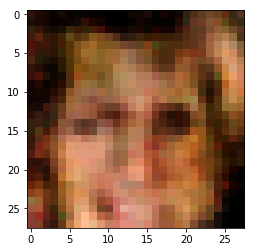

Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.4724


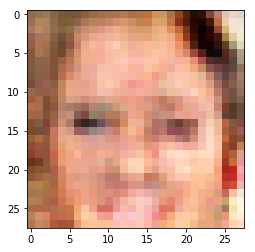

Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.6813


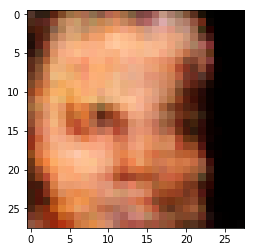

Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 2.6398


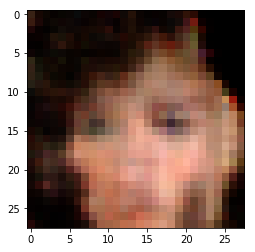

Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.6754


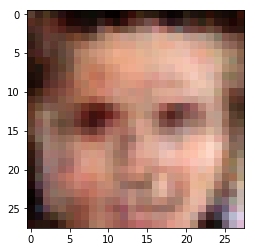

Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.4179


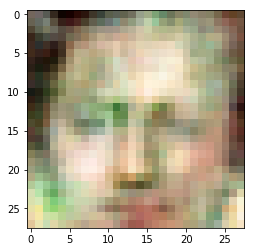

Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.8306


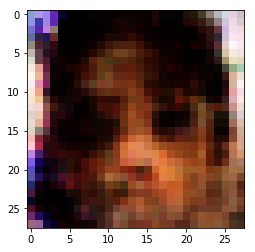

Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.3661


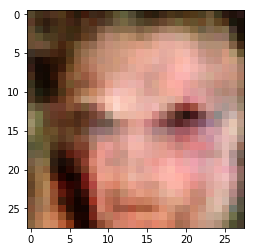

Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 1.0557


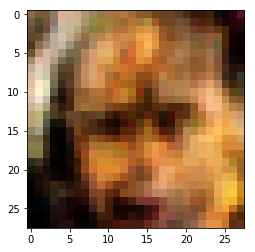

Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 1.8451


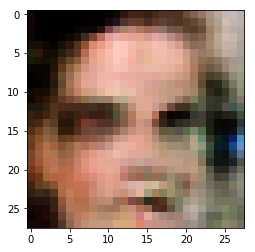

Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.3099


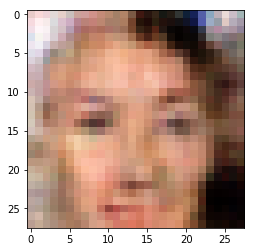

Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.7887


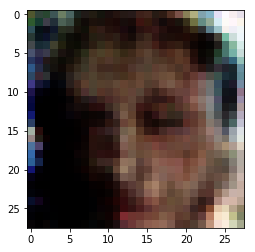

Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.7140


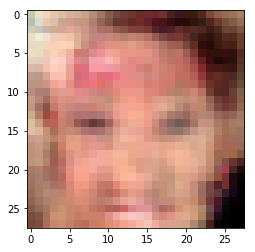

Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 2.0564


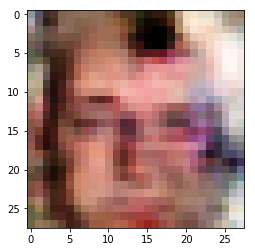

Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 2.0312


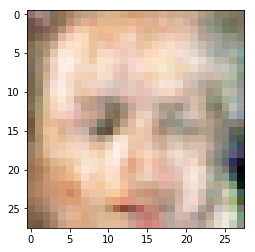

Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 1.3130


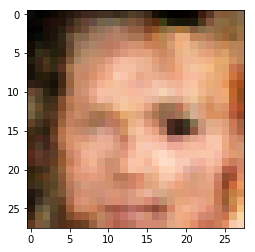

Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 2.3445


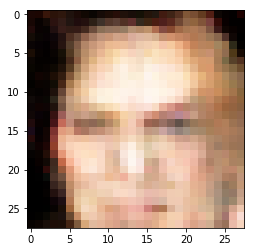

Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.7353


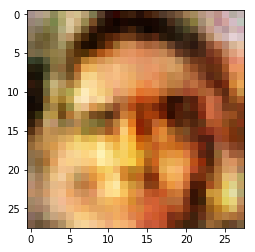

Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.1648


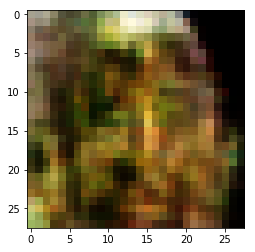

Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 2.0235


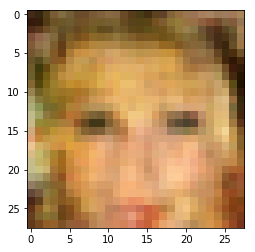

Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 2.4926


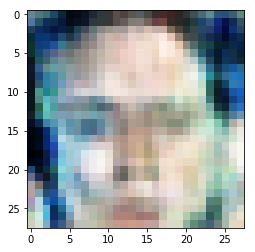

Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.8977


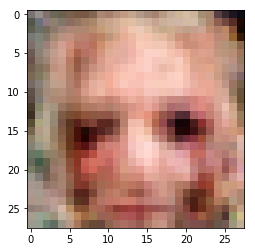

Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 2.8403


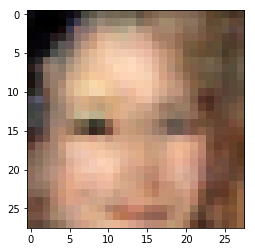

Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.6875


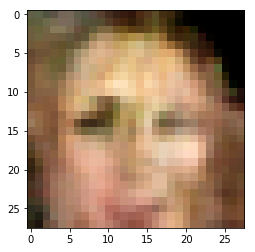

Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.5670


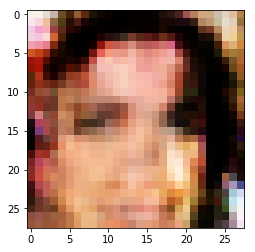

Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.1446


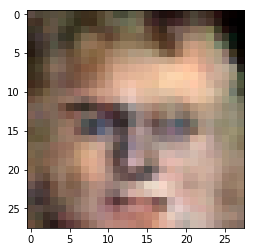

Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.6911


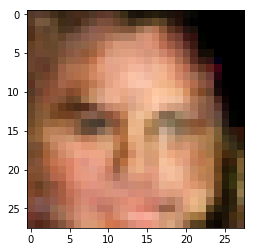

Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.6613


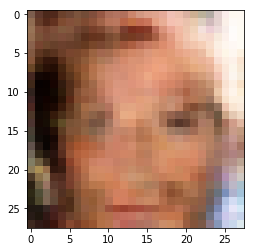

Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.7604


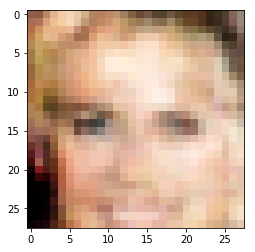

Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.8618


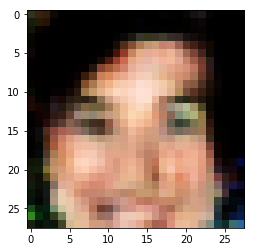

Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 1.0284


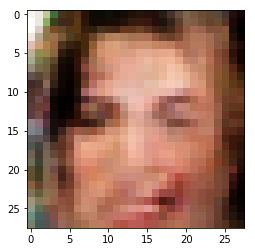

Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.5467


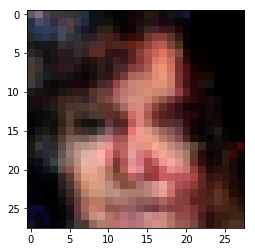

Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 1.7474


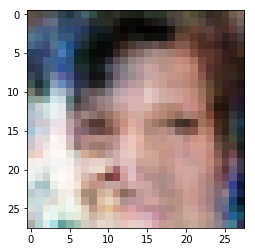

Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 3.0963


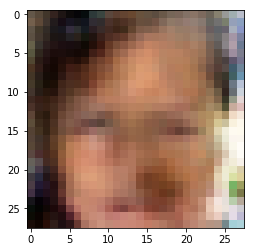

Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 1.5847


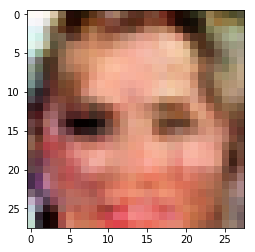

Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.4315


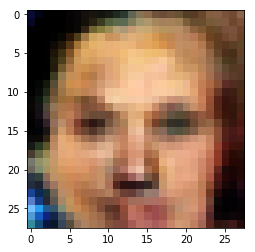

Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.4025


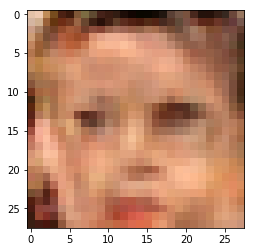

Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 1.0962


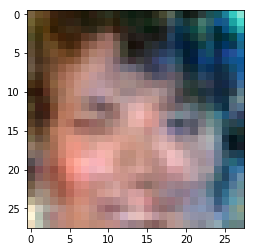

Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 2.2137


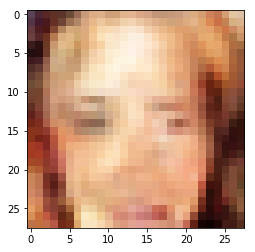

Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 2.1175


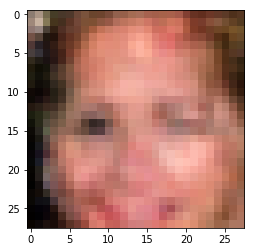

Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 2.3147


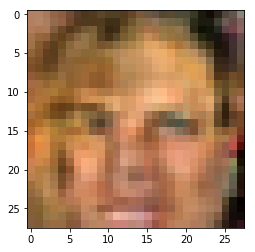

Epoch 1/1... Discriminator Loss: 0.8233... Generator Loss: 1.6817


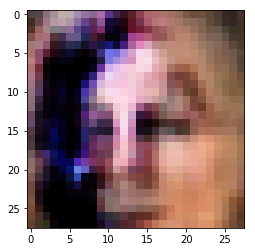

Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.0933


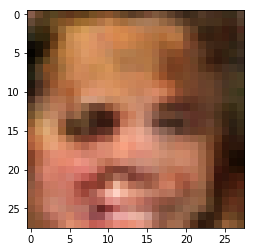

Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.9924


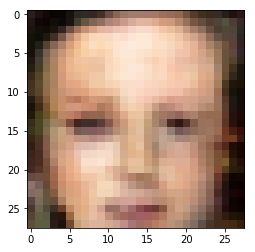

Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 1.3227


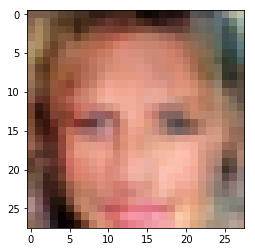

Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 2.2270


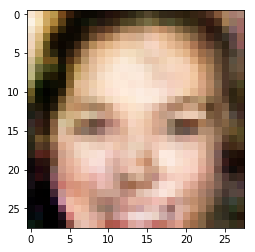

Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.9840


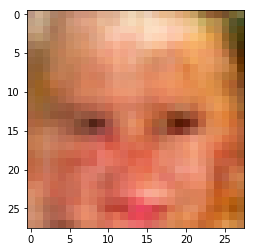

Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 2.5742


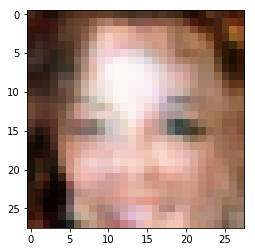

Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.5099


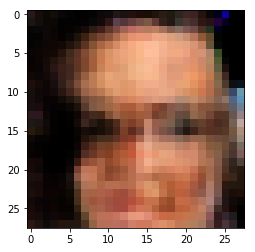

Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 1.3045


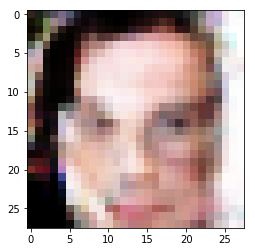

Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 2.4200


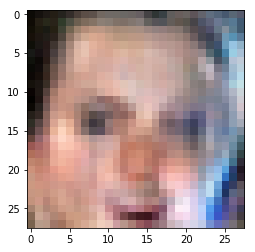

Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 1.5162


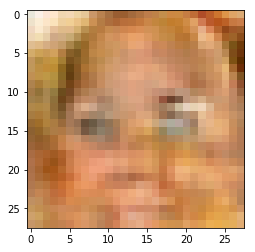

Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 2.2410


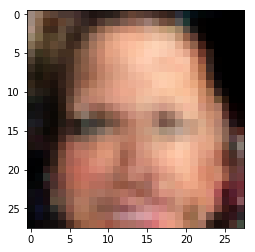

Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 2.0714


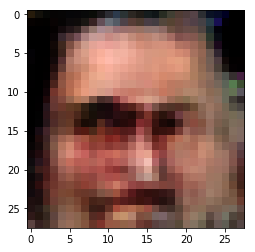

Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.8878


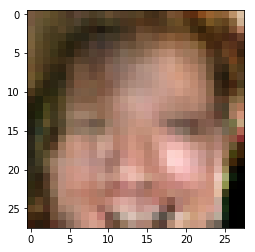

Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.9337


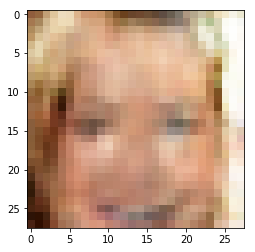

Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 2.5481


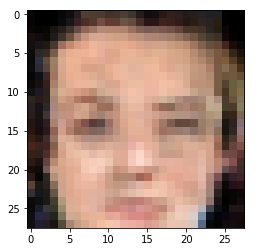

Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.1903


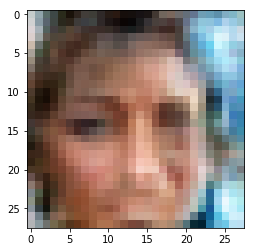

Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 2.0878


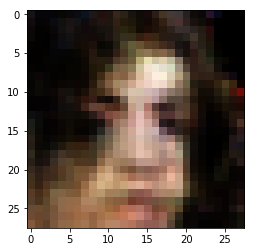

Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.6275


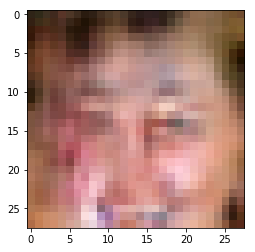

Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.6506


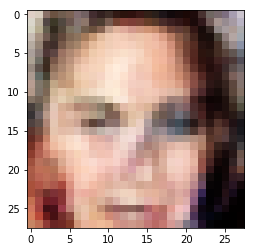

Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 2.2276


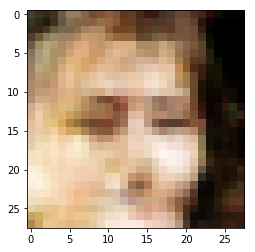

Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 1.4910


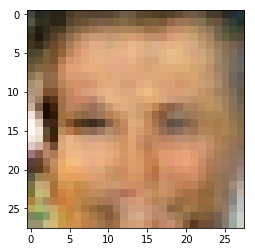

Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 2.3314


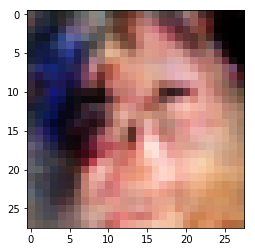

Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 2.8180


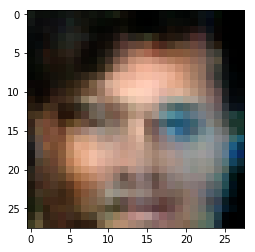

Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 2.1532


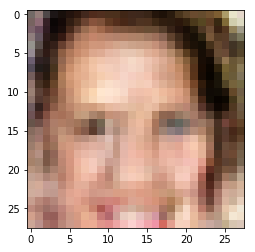

Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 1.5095


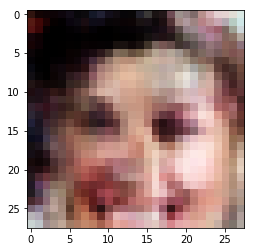

Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 1.1101


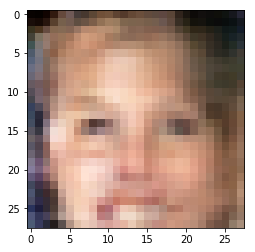

Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.1601


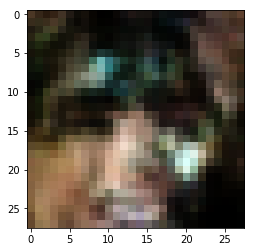

Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 1.3810


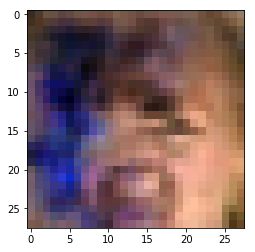

Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.6903


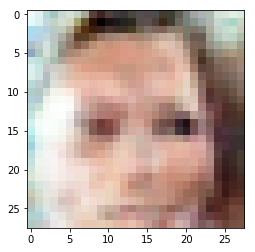

Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.5168


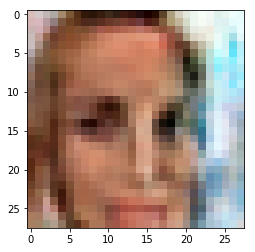

Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.8026


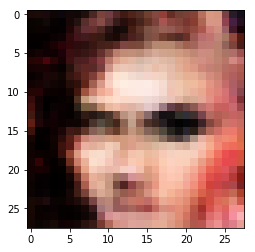

Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.7525


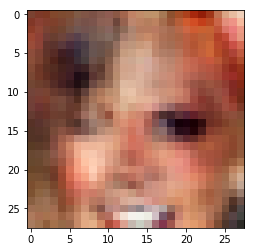

Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.1449


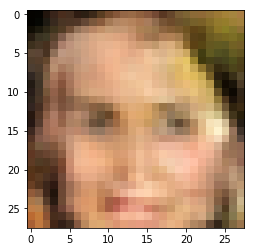

Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.3233


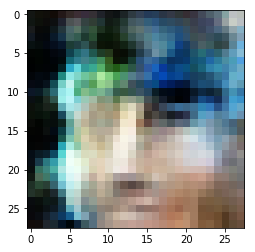

Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.5985


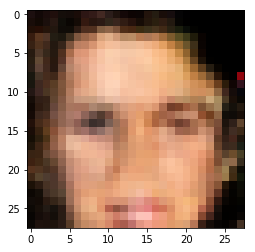

Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 1.6118


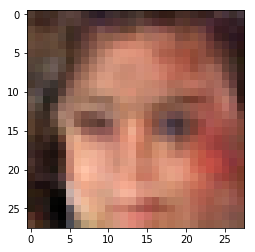

Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.3637


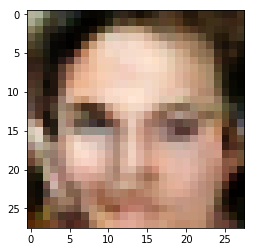

Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.4090


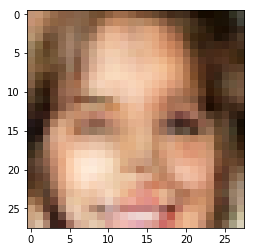

Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.7897


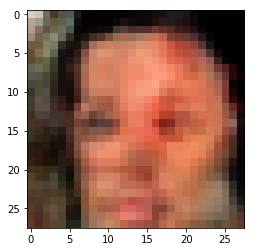

Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 3.1771


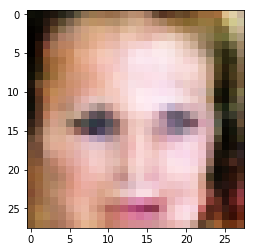

Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.1970


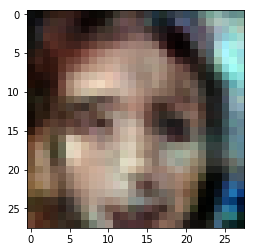

Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.2250


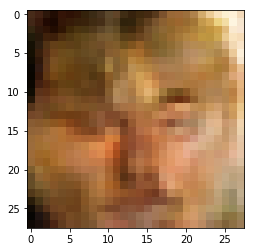

Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.5719


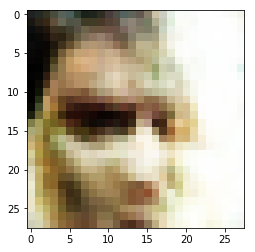

Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.5361


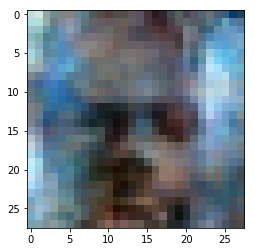

Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 2.4591


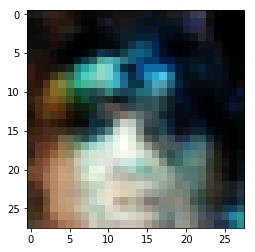

Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 2.7057


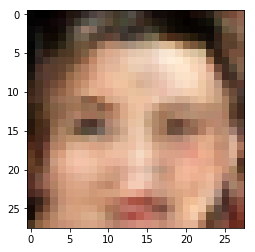

Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 2.7241


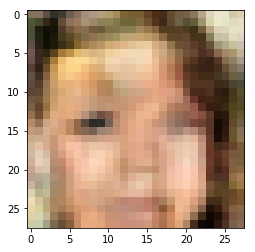

Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 0.8302


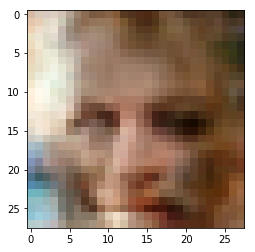

Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 2.0130


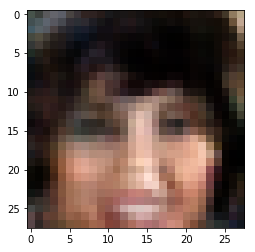

Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.0126


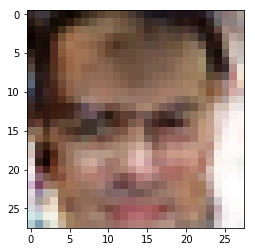

Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.3623


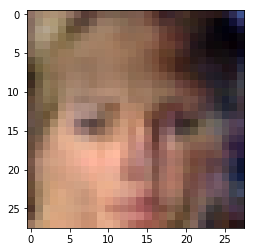

Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 2.5946


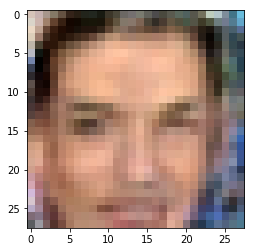

Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.1912


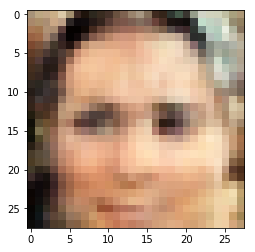

Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.8176


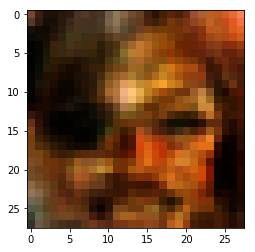

Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 1.5130


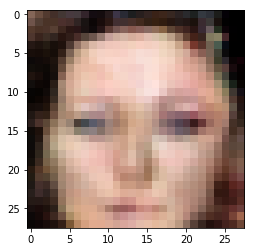

Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 2.1560


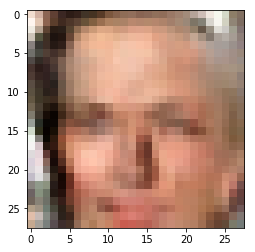

Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.3758


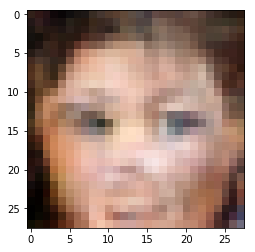

Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.2639


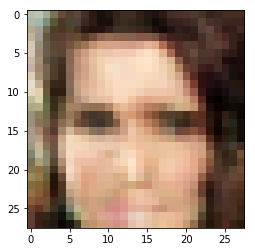

Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.3501


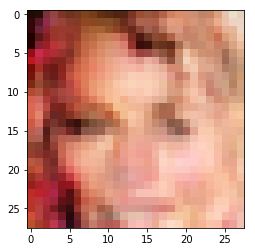

Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.5817


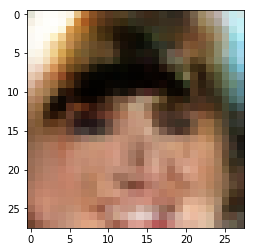

Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 2.3965


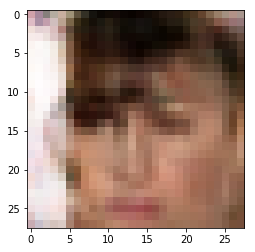

Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 2.1954


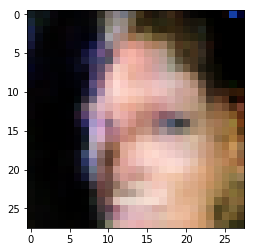

Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.9727


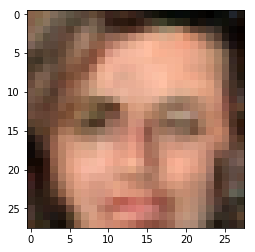

Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.2189


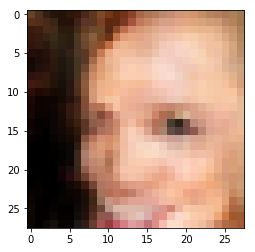

Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 2.5152


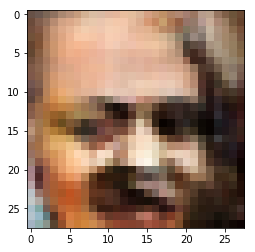

Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.0341


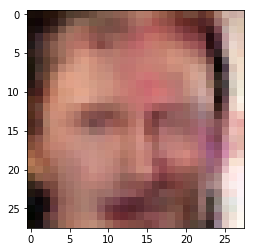

Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.9919


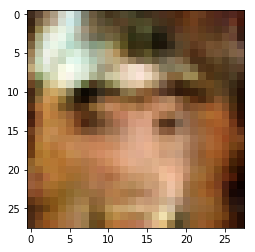

Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 2.1269


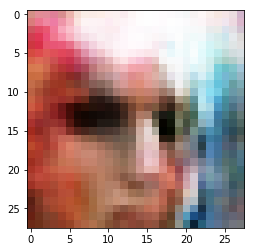

In [46]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.